# Forestry simulation by Monte Carlo for AR+

Bernal et al. (2018) published CO2 removal rates for pine, oak, eucalyptus, teak, conifers (other than pine), and broadleaves (other than eucalyptus and teak) across the climatic regions: boreal, dry temperate, humid temperate, dry tropical, and humid tropical. We used independent uniform random variables to simulate the distribution of land to each combination of planted species and climatic region.

Each planted species and climatic region is assigned a weight that reflects:
1. the distribution of global forest area by climatic region, and
2. the distribution of area of planted forests by species.

Citations:
* Carle, Jim & Holmgren, Peter. (2008). Wood from Planted Forests A Global Outlook 2005-2030. Forest Products Journal. 58. 6-18.
* FAO and UNEP. 2020. The State of the World’s Forests 2020. Forests, biodiversity and people. Rome.
* Kollert, Walter & Kleine, Michael. (2017). The Global Teak Study Analysis, Evaluation and Future Potential of Teak Resources.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import time

regions = ['Boreal', 'Temperate-dry', 'Temperate-humid', 'Tropical-dry', 'Tropical-humid']
tree_types = ['Broadleaf', 'Conifer', 'Eucalyptus', 'Oak', 'Pine', 'Teak']

# Removal rate in years 0-20, in t CO2 ha-1 year-1, from Table 1 on page 5 of Bernal (2018). 
removal_rates = np.array([
    #Broadleaf, Conifer, Eucalyptus, Oak,   Pine,  Teak
    [8.0,       4.5,     0,          0,     10.2,  0   ], # boreal
    [11.8,      6.4,     37.9,       5.3,   7.6,   0   ], # temperate-dry
    [11.8,      11.6,    37.9,       9.5,   21.1,  0   ], # temperate-humid
    [10.7,      38.7,    38.8,       18.4,  21.0,  12.7], # tropical-dry
    [25.3,      23.6,    40.7,       0,     0,     30.8]  # tropical-humid
])

# Constants from Table 6, "Tree Cover Within Protected Areas in 2015, by Global Ecological Zone" on page 115 of
# "The State of the World’s Forests 2020." In Mha.
tree_cover_tropical_rainforest          = 1068
tree_cover_tropical_moist_forest        = 472
tree_cover_tropical_dry_forest          = 218
tree_cover_tropical_mountain_system     = 179
tree_cover_subtropical_humid_forest     = 176
tree_cover_subtropical_dry_forest       = 37
tree_cover_subtropical_mountain_system  = 126
tree_cover_temperate_oceanic_forest     = 55
tree_cover_temperate_continental_forest = 271
tree_cover_temperate_mountain_system    = 257
tree_cover_boreal_coniferous_forest     = 659
tree_cover_boreal_tundra_woodland       = 229
tree_cover_boreal_mountain_system       = 444

# tree_cover_tropical_shrubland = 52    # NOT USED
# tree_cover_tropical_desert    = 5     # NOT USED
# tree_cover_subtropical_steppe = 35    # NOT USED
# tree_cover_subtropical_desert = 14    # NOT USED
# tree_cover_temperate_steppe   = 22    # NOT USED
# tree_cover_temperate_desert   = 15    # NOT USED
# tree_cover_polar              = 35    # NOT USED
# tree_cover_water              = 3     # NOT USED

# Estimate of planted teak from 4.35 to 6.89 Mha from Kollert (2017).
planted_teak_mha = (4.35+6.89)/2

# Constants from Table 7, "Area of planted forests by region and major species groups at 2005 and 
# 2030 for the three scenarios" on page 13 of Carle (2008). In Mha.
planted_eucalyptus_mha = 13.8
planted_conifer_mha = 64
planted_pine_mha = 73.2
planted_hardwood_other_mha = 100.3+9.1
planted_hardwood_exc_teak_eucalyptus_mha = planted_hardwood_other_mha - planted_teak_mha
planted_total_mha = planted_eucalyptus_mha + planted_conifer_mha + planted_pine_mha + planted_hardwood_other_mha

## Global forest area by climatic region

In calculating global forest area by climatic region, we treat temperate and subtropical as the same region. We also treat certain regions as dry versus humid. Our assumptions are visible in the code for: `tree_cover_boreal`, `tree_cover_temperate_dry`, `tree_cover_temperate_humid`, `tree_cover_tropical_dry`, and `tree_cover_tropical_humid`.

** WinRock lumps subtropical with tropical, instead of with temperate. **

In [2]:
tree_cover_total = \
    tree_cover_tropical_rainforest + \
    tree_cover_tropical_moist_forest + \
    tree_cover_tropical_dry_forest + \
    tree_cover_tropical_mountain_system + \
    tree_cover_subtropical_humid_forest + \
    tree_cover_subtropical_dry_forest + \
    tree_cover_subtropical_mountain_system + \
    tree_cover_temperate_oceanic_forest + \
    tree_cover_temperate_continental_forest + \
    tree_cover_temperate_mountain_system + \
    tree_cover_boreal_coniferous_forest + \
    tree_cover_boreal_mountain_system

# Excluded from calculation of tree_cover_total:
#     tree_cover_tropical_shrubland
#     tree_cover_tropical_desert
#     tree_cover_subtropical_steppe
#     tree_cover_subtropical_desert
#     tree_cover_temperate_steppe
#     tree_cover_temperate_desert
#     tree_cover_boreal_tundra_woodland
#     tree_cover_polar
#     tree_cover_water

"""
William version:
- Boreal forests - include tundra woodland
- Tropical Dry Forest - include all of tropical mountain system
- Temp Dry - include all subtropical and temp mountain system
- Temp Humid - Subtrop humid, temp oceanic and temp continental
tree_cover_boreal          = tree_cover_boreal_coniferous_forest + tree_cover_boreal_tundra_woodland + tree_cover_boreal_mountain_system
tree_cover_temperate_dry   = tree_cover_subtropical_dry_forest + tree_cover_subtropical_mountain_system + tree_cover_temperate_mountain_system    
tree_cover_temperate_humid = tree_cover_subtropical_humid_forest + tree_cover_temperate_oceanic_forest + tree_cover_temperate_continental_forest
tree_cover_tropical_dry    = tree_cover_tropical_dry_forest + tree_cover_tropical_mountain_system
tree_cover_tropical_humid  = tree_cover_tropical_rainforest + tree_cover_tropical_moist_forest
"""

"""
Luke version (based on latest feedback from WinRock):
- Boreal forests - exclude tundra woodland (not enough tree density)
- Split tropical mountain system 50-50 between Tropical Dry Forest and  Tropical Humid Forest 
- Temp Dry - temp continental forest and 50% temp mountain systems
- Temp Humid - temp oceanic and 50% emp mountain systems
- Tropical Dry - tropical dry, substropical dry and 50% (tropical mountain systems + subtropical mountain systems)
- Tropical Humid - tropical rainforest, substropical humid and 50% (tropical mountain systems + subtropical mountain systems)
"""
tree_cover_boreal          = tree_cover_boreal_coniferous_forest + tree_cover_boreal_mountain_system
tree_cover_temperate_dry   = tree_cover_temperate_continental_forest + tree_cover_temperate_mountain_system/2    
tree_cover_temperate_humid = tree_cover_temperate_oceanic_forest + tree_cover_temperate_mountain_system/2  
tree_cover_tropical_dry    = tree_cover_tropical_dry_forest + tree_cover_subtropical_dry_forest + \
            (tree_cover_subtropical_mountain_system + tree_cover_tropical_mountain_system)/2 
tree_cover_tropical_humid  = tree_cover_tropical_rainforest + tree_cover_tropical_moist_forest + \
            tree_cover_subtropical_humid_forest + \
            (tree_cover_subtropical_mountain_system + tree_cover_tropical_mountain_system)/2 

boreal_perc     = tree_cover_boreal          / tree_cover_total
temp_dry_perc   = tree_cover_temperate_dry   / tree_cover_total
temp_humid_perc = tree_cover_temperate_humid / tree_cover_total
trop_dry_perc   = tree_cover_tropical_dry    / tree_cover_total
trop_humid_perc = tree_cover_tropical_humid  / tree_cover_total

print(tree_cover_temperate_dry, tree_cover_temperate_humid)
print(tree_cover_temperate_oceanic_forest + \
    tree_cover_temperate_continental_forest + \
    tree_cover_temperate_mountain_system)

show_data = [
    [tree_cover_boreal, tree_cover_temperate_dry, tree_cover_temperate_humid, tree_cover_tropical_dry, tree_cover_tropical_humid],
    [boreal_perc, temp_dry_perc, temp_humid_perc, trop_dry_perc, trop_humid_perc]
]
df = pd.DataFrame(show_data, columns=['Boreal', 'Temperate-dry', 'Temperate-humid', 'Tropical-dry', 'Tropical-humid']).round(3)
df['Total'] = df.sum(axis=1)
df
# Tree cover by Mha and proportion. Sanity-check that percentages sum to 1.0.

399.5 183.5
583


,Boreal,Temperate-dry,Temperate-humid,Tropical-dry,Tropical-humid,Total
0,1103.000,399.500,183.500,407.500,1868.500,3962.0
1,0.278,0.101,0.046,0.103,0.472,1.0


## Area of planted forests by species

Distribution by planted species is based on Carle et al. (2005), which reported: 73.2 Mha of planted pine, 64 Mha of other software (conifers), 13.8 Mha of eucalyptus, and 109.4 Mha of non-eucalyptus hardwood (broadleaves). Walter et al. (2017) estimated planted teak forest area in the range of 4.35 to 6.89 Mha. Our simulation assumes a midpoint value for planted teak (5.62 Mha). We also assume that oak is one-quarter of planted hardwood excluding eucalyptus and teak.

In [3]:
# William - Assume oak is 1/4 of hardwood ex teak and eucalyptus
# planted_oak_mha       = planted_hardwood_exc_teak_eucalyptus_mha * 0.25
# planted_broadleaf_mha = planted_hardwood_exc_teak_eucalyptus_mha * 0.75

# Luke - Assume oak is 1/10 of of hardwood ex teak and eucalyptus
planted_oak_mha       = planted_hardwood_exc_teak_eucalyptus_mha * 0.1
planted_broadleaf_mha = planted_hardwood_exc_teak_eucalyptus_mha * 0.9

# Corey - Assume oak is 1/100 of of hardwood ex teak and eucalyptus
# planted_oak_mha       = planted_hardwood_exc_teak_eucalyptus_mha * 0.01
# planted_broadleaf_mha = planted_hardwood_exc_teak_eucalyptus_mha * 0.99

planted_broadleaf_perc  = planted_broadleaf_mha  / planted_total_mha
planted_conifer_perc    = planted_conifer_mha    / planted_total_mha
planted_eucalyptus_perc = planted_eucalyptus_mha / planted_total_mha
planted_oak_perc        = planted_oak_mha        / planted_total_mha
planted_pine_perc       = planted_pine_mha       / planted_total_mha
planted_teak_perc       = planted_teak_mha       / planted_total_mha

broadleaf_to_other_perc = planted_broadleaf_perc / (planted_broadleaf_perc+planted_conifer_perc)
conifer_to_other_perc   = planted_conifer_perc   / (planted_broadleaf_perc+planted_conifer_perc)

show_data = [[planted_broadleaf_perc,
              planted_conifer_perc, 
              planted_eucalyptus_perc, 
              planted_oak_perc, 
              planted_pine_perc, 
              planted_teak_perc,
              planted_broadleaf_perc + planted_conifer_perc + planted_eucalyptus_perc + planted_oak_perc + planted_pine_perc + planted_teak_perc
             ]
]
pd.DataFrame(show_data, columns=['Broadleaf', 'Conifer', 'Eucalyptus', 'Oak', 'Pine', 'Teak', 'Total']).round(2)

# Planted forests by species. Sanity-check that percentages sum to 1.0.

,Broadleaf,Conifer,Eucalyptus,Oak,Pine,Teak,Total
0,0.36,0.25,0.05,0.04,0.28,0.02,1.0


Given data already quoted, assume that planted species are equally distributed across the climatic regions in which they are grown. For example, teak is grown in tropical dry and tropical humid regions. The planted teak in these two regions should sum to the teak percentage calculated above. Likewise for oak (grown in 3 of 5 regions), eucalyptus (grown in 4 of 5 regions), and pine (grown in 4 of 5 regions).

In [4]:
trop_dry_teak         = planted_teak_perc * (trop_dry_perc/(trop_dry_perc+trop_humid_perc))
trop_humid_teak       = planted_teak_perc * (trop_humid_perc/(trop_dry_perc+trop_humid_perc))

temp_dry_oak          = planted_oak_perc * (temp_dry_perc  /(temp_dry_perc+temp_humid_perc+trop_dry_perc))
temp_humid_oak        = planted_oak_perc * (temp_humid_perc/(temp_dry_perc+temp_humid_perc+trop_dry_perc))
trop_dry_oak          = planted_oak_perc * (trop_dry_perc  /(temp_dry_perc+temp_humid_perc+trop_dry_perc))

temp_dry_eucalyptus   = planted_eucalyptus_perc * (temp_dry_perc  /(temp_dry_perc+temp_humid_perc+trop_dry_perc+trop_humid_perc))
temp_humid_eucalyptus = planted_eucalyptus_perc * (temp_humid_perc/(temp_dry_perc+temp_humid_perc+trop_dry_perc+trop_humid_perc))
trop_dry_eucalyptus   = planted_eucalyptus_perc * (trop_dry_perc  /(temp_dry_perc+temp_humid_perc+trop_dry_perc+trop_humid_perc))
trop_humid_eucalyptus = planted_eucalyptus_perc * (trop_humid_perc/(temp_dry_perc+temp_humid_perc+trop_dry_perc+trop_humid_perc))

boreal_pine           = planted_pine_perc * (boreal_perc    /(boreal_perc+temp_dry_perc+temp_humid_perc+trop_dry_perc))
temp_dry_pine         = planted_pine_perc * (temp_dry_perc  /(boreal_perc+temp_dry_perc+temp_humid_perc+trop_dry_perc))
temp_humid_pine       = planted_pine_perc * (temp_humid_perc/(boreal_perc+temp_dry_perc+temp_humid_perc+trop_dry_perc))
trop_dry_pine         = planted_pine_perc * (trop_dry_perc  /(boreal_perc+temp_dry_perc+temp_humid_perc+trop_dry_perc))

boreal_broadleaf      = broadleaf_to_other_perc*(boreal_perc-boreal_pine)
temp_dry_broadleaf    = broadleaf_to_other_perc*(temp_dry_perc-temp_dry_oak-temp_dry_eucalyptus-temp_dry_pine)
temp_humid_broadleaf  = broadleaf_to_other_perc*(temp_humid_perc-temp_humid_oak-temp_humid_eucalyptus-temp_humid_pine)
trop_dry_broadleaf    = broadleaf_to_other_perc*(trop_dry_perc-trop_dry_teak-trop_dry_oak-trop_dry_eucalyptus-trop_dry_pine)
trop_humid_broadleaf  = broadleaf_to_other_perc*(trop_humid_perc-trop_humid_teak-trop_humid_eucalyptus)

boreal_conifer        = conifer_to_other_perc*(boreal_perc-boreal_pine)
temp_dry_conifer      = conifer_to_other_perc*(temp_dry_perc-temp_dry_oak-temp_dry_eucalyptus-temp_dry_pine)
temp_humid_conifer    = conifer_to_other_perc*(temp_humid_perc-temp_humid_oak-temp_humid_eucalyptus-temp_humid_pine)
trop_dry_conifer      = conifer_to_other_perc*(trop_dry_perc-trop_dry_teak-trop_dry_oak-trop_dry_eucalyptus-trop_dry_pine)
trop_humid_conifer    = conifer_to_other_perc*(trop_humid_perc-trop_humid_teak-trop_humid_eucalyptus)

weights = np.array([
    #Broadleaf           , Conifer           , Eucalyptus           , Oak           , Pine           , Teak
    [boreal_broadleaf    , boreal_conifer    , 0                    , 0             , boreal_pine    , 0              ], # boreal
    [temp_dry_broadleaf  , temp_dry_conifer  , temp_dry_eucalyptus  , temp_dry_oak  , temp_dry_pine  , 0              ], # temperate-dry
    [temp_humid_broadleaf, temp_humid_conifer, temp_humid_eucalyptus, temp_humid_oak, temp_humid_pine, 0              ], # temperate-humid
    [trop_dry_broadleaf  , trop_dry_conifer  , trop_dry_eucalyptus  , trop_dry_oak  , trop_dry_pine  , trop_dry_teak  ], # tropical-dry
    [trop_humid_broadleaf, trop_humid_conifer, trop_humid_eucalyptus, 0             , 0              , trop_humid_teak]  # tropical-humid
])

df = pd.DataFrame(weights.round(3), columns=['Broadleaf', 'Conifer', 'Eucalyptus', 'Oak', 'Pine', 'Teak'])
df.insert(0, 'Climatic Region', regions)
df['Total'] = df.sum(axis=1)
df = df.append(df.sum(numeric_only=True), ignore_index=True)
df

# Weights by climatic region and planted forest. Sanity-check that columns sum to species distributions, 
# that rows sum to regional distributions, and that all sum to 1.0.

/var/folders/sq/dq134znj6wb0wp0vrmxsytxr0000gn/T/ipykernel_29995/2561806386.py:41: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['Total'] = df.sum(axis=1)
/var/folders/sq/dq134znj6wb0wp0vrmxsytxr0000gn/T/ipykernel_29995/2561806386.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df.sum(numeric_only=True), ignore_index=True)


,Climatic Region,Broadleaf,Conifer,Eucalyptus,Oak,Pine,Teak,Total
0,Boreal,0.077,0.053,0.000,0.000,0.148,0.000,0.278
1,Temperate-dry,0.014,0.010,0.007,0.016,0.054,0.000,0.101
2,Temperate-humid,0.006,0.004,0.003,0.007,0.025,0.000,0.045
3,Tropical-dry,0.012,0.008,0.008,0.016,0.055,0.004,0.103
4,Tropical-humid,0.249,0.170,0.035,0.000,0.000,0.018,0.472
5,NaN,0.358,0.245,0.053,0.039,0.282,0.022,0.999


## Ready to run the simulation!

In [5]:
num_simulations = 100000
num_billion_hectares = 0.5

# Returns: carbon removal rate of 1 hectare, in t CO2 ha-1 year-1, above ground biomass
#          flattened array of contribution by climatic region and tree type.
def simulate():
    trees_sim_raw = np.random.rand(len(regions), len(tree_types)) * weights
    trees_sim_denom = np.sum(trees_sim_raw)
    trees_sim = trees_sim_raw / trees_sim_denom

    removal_rates_sim = (trees_sim * removal_rates).sum()
    # print(np.sum(trees_sim_raw),np.sum(trees_sim), np.sum(removal_rates_sim))
    return removal_rates_sim, trees_sim.flatten()

removal_rate_results = []
land_percentage_results = []
for i in range(num_simulations):
    removal_rate, land_percentages = simulate()
    removal_rate_results.append(removal_rate * num_billion_hectares)
    land_percentage_results.append(land_percentages)

result_arr = np.sort(np.array(removal_rate_results))
med = np.percentile(result_arr, 50)
std = np.std(result_arr)

print('In {} simulations, carbon removal rate (in Gt CO2/yr) of AR+ on {:,} hectares is...'.format(num_simulations, num_billion_hectares))
print('10th perc: {:,.2f}'.format(np.percentile(result_arr, 10)))
print('25th perc: {:,.2f}'.format(np.percentile(result_arr, 25)))
print('Median   : {:,.2f}'.format(med))
print('Mean     : {:,.2f}'.format(np.mean(result_arr)))
print('75th perc: {:,.2f}'.format(np.percentile(result_arr, 75)))
print('90th perc: {:,.2f}'.format(np.percentile(result_arr, 90)))
print('Std dev  : {:,.2f}'.format(std))
print('Interval : {:,.2f} - {:,.2f}'.format(med-std, med+std))

In 100000 simulations, carbon removal rate (in Gt CO2/yr) of AR+ on 0.5 hectares is...
10th perc: 8.21
25th perc: 8.79
Median   : 9.37
Mean     : 9.32
75th perc: 9.90
90th perc: 10.35
Std dev  : 0.83
Interval : 8.53 - 10.20


(0.0, 2460.0)

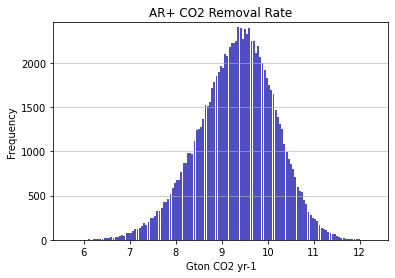

In [6]:
n, bins, patches = plt.hist(x=removal_rate_results, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Gton CO2 yr-1')
plt.ylabel('Frequency')
plt.title('AR+ CO2 Removal Rate')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 + 50 if maxfreq % 10 else maxfreq + 50)

# Implement CO2 Removal Rate as normal distributions

Key changes:

*   CO2 removal rates of forests are sampled from normal distribution with Mu and Sigma from Bernal et al (2018) Table 1
*   Subtropical is lumped together with tropical, instead of with temperate (Implemented in cell above).



In [7]:
# Implement CO2 removal rate as normal distributions based on Bernal (2018). 
removal_rates_mu = np.array([
    #Broadleaf, Conifer, Eucalyptus, Oak,   Pine,  Teak
    [8.0,       4.5,     0,          0,     10.2,  0   ], # boreal
    [11.8,      6.4,     37.9,       5.3,   7.6,   0   ], # temperate-dry
    [11.8,      11.6,    37.9,       9.5,   21.1,  0   ], # temperate-humid
    [10.7,      38.7,    38.8,       18.4,  21.0,  12.7], # tropical-dry
    [25.3,      23.6,    40.7,       0,     0,     30.8]  # tropical-humid
])
removal_rates_half_ci95 = np.array([
    #Broadleaf, Conifer, Eucalyptus, Oak,   Pine,  Teak
    [1.0,       1.0,     0,          0,     4.9,   0   ], # boreal
    [1.4,       1.9,     5.5,        3.5,   2.0,   0   ], # temperate-dry
    [1.4,       3.6,     5.5,        3.5,   4.5,   0   ], # temperate-humid
    [0.6,       2.5,     6.0,        1.0,   2.0,   1.5 ], # tropical-dry
    [3.9,       2.8,     9.5,        0,     0,     4.1 ]  # tropical-humid
])
removal_rates_n_sample_size = np.array([
    #Broadleaf, Conifer, Eucalyptus, Oak,   Pine,  Teak
    [13,        22,      0,          0,     10,    0   ], # boreal
    [77,        13,      52,         6,     12,    0   ], # temperate-dry
    [77,        41,      52,         11,    41,    0   ], # temperate-humid
    [6,         6,       32,         13,    28,    25  ], # tropical-dry
    [54,        24,      13,         0,     0,     34  ]  # tropical-humid
])

# z score for 95% confidence interval assuming normal distirbution
z = 1.96

removal_rates_se = removal_rates_half_ci95 / z

# sigma = HalfCI95/z_value

# Multiplying by the sqrt of n leads to much higher variance.
# removal_rates_sigma = removal_rates_se
removal_rates_sigma = removal_rates_se * np.sqrt(removal_rates_n_sample_size)


In [8]:
num_simulations = 100000
num_billion_hectares = 0.5

# Returns: carbon removal rate of 1 hectare, in t CO2 ha-1 year-1, above ground biomass
#          flattened array of contribution by climatic region and tree type.
def simulate():
    trees_sim_raw = np.random.rand(len(regions), len(tree_types)) * weights
    trees_sim_denom = np.sum(trees_sim_raw)
    trees_sim = trees_sim_raw / trees_sim_denom

    # Luke - This is the only modification needs to implement CO2 removal rates as norm dist
    removal_rates_raw = np.random.normal(removal_rates_mu, removal_rates_sigma, (1,5,6))
    removal_rates_sim = (trees_sim * removal_rates_raw).sum()
    
    return removal_rates_sim, trees_sim.flatten()

removal_rate_results = []
land_percentage_results = []
for i in range(num_simulations):
    removal_rate, land_percentages = simulate()
    removal_rate_results.append(removal_rate * num_billion_hectares)
    land_percentage_results.append(land_percentages)

result_arr = np.sort(np.array(removal_rate_results))
med = np.percentile(result_arr, 50)
std = np.std(result_arr)

# Calculate 95% confidence interval
print('In {} simulations, carbon removal rate (in Gt CO2/yr) of AR+ on {:,} hectares is...'.format(num_simulations, num_billion_hectares))
print('2.5th perc: {:,.2f}'.format(np.percentile(result_arr, 2.5)))
# print('25th perc: {:,.2f}'.format(np.percentile(result_arr, 25)))
print('Median   : {:,.2f}'.format(med))
print('Mean     : {:,.2f}'.format(np.mean(result_arr)))
# print('75th perc: {:,.2f}'.format(np.percentile(result_arr, 75)))
print('97.5th perc: {:,.2f}'.format(np.percentile(result_arr, 97.5)))
print('Std dev  : {:,.2f}'.format(std))
print('Interval : {:,.2f} - {:,.2f}'.format(med-std, med+std))
print('95% CI : {:,.2f} - {:,.2f}'.format(np.percentile(result_arr, 2.5), np.percentile(result_arr, 97.5)))

In 100000 simulations, carbon removal rate (in Gt CO2/yr) of AR+ on 0.5 hectares is...
2.5th perc: 4.92
Median   : 9.19
Mean     : 9.31
97.5th perc: 14.40
Std dev  : 2.38
Interval : 6.80 - 11.57
95% CI : 4.92 - 14.40


(0.0, 2430.0)

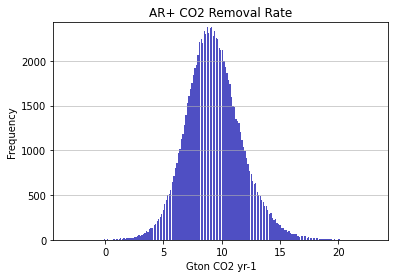

In [9]:
n, bins, patches = plt.hist(x=removal_rate_results, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Gton CO2 yr-1')
plt.ylabel('Frequency')
plt.title('AR+ CO2 Removal Rate')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 + 50 if maxfreq % 10 else maxfreq + 50)

In [10]:
num_simulations = 10000

def simulate():
    # data = np.random.normal(9.5, 3.5/1.96)
    data = np.random.normal(9.5, 3.5*np.sqrt(11)/1.96) 
    return data

data_results = []
land_percentage_results = []
for i in range(num_simulations):
    data = simulate()
    data_results.append(data)

result_arr = np.sort(np.array(data_results))
med = np.percentile(result_arr, 50)
std = np.std(result_arr)

print('Mean     : {:,.2f}'.format(np.mean(result_arr)))
print('95% CI : {:,.2f} - {:,.2f}'.format(np.percentile(result_arr, 2.5), np.percentile(result_arr, 97.5)))

Mean     : 9.45
95% CI : -2.04 - 20.94
